In [32]:
import csv
import matplotlib
#matplotlib.rcParams['font.family'] = "Times New Roman"
import seaborn as sns
sns.set_style("whitegrid")
def_font_size = 20

#matplotlib.rcParams['font.size'] = def_font_size=16
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams["axes.grid"] = True
matplotlib.rcParams["lines.linewidth"] = 4
matplotlib.rcParams["lines.markersize"] = 12
matplotlib.rcParams["xtick.labelsize"] = 24
matplotlib.rcParams["ytick.labelsize"] = 24



matplotlib.rc("axes", **{"labelsize": 28, "titlesize": "large"})
matplotlib.rc("legend", **{"fontsize": "medium"})
matplotlib.rcParams["figure.figsize"] = (8, 5)

In [33]:
from weight_shared_analyzer import WeightSharedRun, plot_pareto_curves_ws, get_pareto_curves_df
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [34]:
smallest_subnet = {"d":0, "e": 0.2}
small_subnet = {"d":1, "e": 0.2}
middle_subnet = {"d":1, "e": 0.5}
large_subnet = {"d":1, "e": 1.0}
largest_subnet = {"d":2, "e": 1.0}
pareto_front_repr = [smallest_subnet, small_subnet, middle_subnet, large_subnet, largest_subnet]
pareto_mapping = {f"{smallest_subnet}": 0.316,  f"{small_subnet}": 0.560, f"{middle_subnet}": 1.290, f"{large_subnet}" : 2.506, f"{largest_subnet}" : 3.722}
subnet_ordering = [0.316, 0.560, 1.290, 2.506, 3.722]

In [35]:
def max_per_seed(seeds, uptil_r, mode="avg", fedavg=True):
    best_accs = []
    for s in seeds:
        cur_s = WeightSharedRun(s, pareto_front_repr, pareto_mapping)
        if fedavg:
            cur_best_acc, _ = get_pareto_curves_df([cur_s], "Test/{model}/Acc", larger_is_better=True, uptil_round=uptil_r, axis=0)
            best_accs.append(cur_best_acc[0])
            #print("curbestacc: ", cur_best_acc, type(cur_best_acc), cur_best_acc[0])
        else:
            cur_best_acc, _ = get_pareto_curves_df([cur_s], "Test/{model}/Acc", larger_is_better=Ture, uptil_round=uptil_r, rename=True, mode=mode)
            cur_list = []
            for order in subnet_ordering:
                cur_list.append(cur_best_acc.at[order, cur_best_acc.columns[0]])
                #print("curbestacc: ", order, cur_best_acc.at[order, cur_best_acc.columns[0]], type(cur_best_acc.at[order, cur_best_acc.columns[0]]))
            best_accs.append(cur_list)
    return best_accs

In [36]:
def fedavgCurves_dep(smallest, small, middle, large, largest):
    fedavg_smallest = WeightSharedRun(smallest, pareto_front_repr, pareto_mapping)
    fedavg_small = WeightSharedRun(small, pareto_front_repr, pareto_mapping)
    fedavg_middle = WeightSharedRun(middle, pareto_front_repr, pareto_mapping)
    fedavg_large = WeightSharedRun(large, pareto_front_repr, pareto_mapping)
    fedavg_largest = WeightSharedRun(largest, pareto_front_repr, pareto_mapping)

    print(fedavg_smallest.name)
    print(fedavg_smallest.df["round"].max())

    print(fedavg_small.name)
    print(fedavg_small.df["round"].max())

    print(fedavg_middle.name)
    print(fedavg_middle.df["round"].max())
    
    print(fedavg_large.name)
    print(fedavg_large.df["round"].max())

    print(fedavg_largest.name)
    print(fedavg_largest.df["round"].max())
    return [fedavg_smallest, fedavg_small, fedavg_middle, fedavg_large, fedavg_largest]

def fedavgCurves(smallest, small, middle, large, largest, uptil_r=1500):
    smallest = max_per_seed(smallest, uptil_r)
    small = max_per_seed(small, uptil_r)
    middle = max_per_seed(middle, uptil_r)
    large = max_per_seed(large, uptil_r)
    largest = max_per_seed(largest, uptil_r)
    return [smallest, small, middle, large, largest]

In [37]:
def fed_paretos_internal(fedavg_runs, name="iFedAvg"):
    avg_acc = []
    std_acc = []
    for run in fedavg_runs:
        avg_acc.append(np.mean(run))
        std_acc.append(np.std(run))
    fed_pareto = pd.Series(data=avg_acc, index=subnet_ordering, name=name)
    error_fed_pareto = pd.Series(data=std_acc, index=subnet_ordering, name=name)
    return fed_pareto, error_fed_pareto

def ws_paretos_internal(seeds, rnum, name="SuperFed", mode="avg"):
    print(f"{name} pareto generation running...")
    ws = max_per_seed(seeds, rnum, mode=mode, fedavg=False)
    avg_acc = np.mean(ws, axis=0)
    std_acc = np.std(ws, axis=0)
    ws_pareto = pd.Series(data=avg_acc, index=subnet_ordering, name=name)
    error_ws_pareto = pd.Series(data=std_acc, index=subnet_ordering, name=name)
    return ws_pareto, error_ws_pareto

def fed_paretos(smallest, small, middle, large, largest, uptil_r=1500, name="iFedAvg"):
    print("fed pareto generation running...")
    return fed_paretos_internal(fedavgCurves(smallest, small, middle, large, largest, uptil_r), name)

def ws_paretos(ws_runs, rnum, names, mode="avg", modify_names=None):
    ws_concat_list = []
    error_ws_concat_list = []
    for ws_run, name in zip(ws_runs, names):
        cur_pareto, cur_error_pareto = ws_paretos_internal(ws_run, rnum, name=name, mode=mode)
        if modify_names is not None and name in modify_names.keys():
            with open(modify_names[name], newline='') as csvfile:
                csvReader = csv.reader(csvfile, delimiter=' ')
                for row in csvReader:
                    cur_pareto[float(row[0])] = float(row[1])
                    cur_error_pareto[float(row[0])] = float(row[2])
            cur_pareto.sort_index(inplace=True)
            cur_error_pareto.sort_index(inplace=True)
        ws_concat_list.append(cur_pareto)
        error_ws_concat_list.append(cur_error_pareto)
    return pd.concat(ws_concat_list, axis=1), pd.concat(error_ws_concat_list, axis=1)

In [38]:
markersize_def = 8
def adv_plot(fed_pareto, error_fed_pareto, ws_pareto, error_ws_pareto, ax_fill_list, ylim_1, ylim_2, 
             rnum, save_name, xlim_1=0.3, xlim_2=3.5, mode="avg", exclude_fedavg=False, colors=None,
            leg_font_size=def_font_size, ncol=1, leg_ordering=None, markers=None):
    #matplotlib.style.use("seaborn-whitegrid")
    if not exclude_fedavg:
        final_df = pd.concat([fed_pareto, ws_pareto], axis=1)
        final_error_df = pd.concat([error_fed_pareto, error_ws_pareto], axis=1)
    else:
        final_df = pd.concat([ws_pareto], axis=1)
        final_error_df = pd.concat([error_ws_pareto], axis=1)
    if colors is not None:
        ax = None
        for i, (col, ax_fill, color) in enumerate(zip(final_df.columns, ax_fill_list, colors)):
            cur_col = final_df.loc[:, [col]]
            cur_col.dropna(inplace=True)
            ax = cur_col.plot.line(marker='o' if markers is None else markers[i], color=color, ax=ax, markersize=markersize_def)
            cur_error_col = final_error_df.loc[:, [col]]
            cur_error_col.dropna(inplace=True)
            ax.fill_between(cur_col.index, cur_col[ax_fill[0]] - cur_error_col[ax_fill[0]], cur_col[ax_fill[0]] + cur_error_col[ax_fill[0]], alpha=ax_fill[1], color=color)
    else:
        ax = None
        for i, (col, ax_fill) in enumerate(zip(final_df.columns, ax_fill_list)):
            cur_col = final_df.loc[:, [col]]
            cur_col.dropna(inplace=True)
            ax = cur_col.plot.line(marker='o' if markers is None else markers[i], ax=ax, markersize=markersize_def)
            cur_error_col = final_error_df.loc[:, [col]]
            cur_error_col.dropna(inplace=True)
            ax.fill_between(cur_col.index, cur_col[ax_fill[0]] - cur_error_col[ax_fill[0]], cur_col[ax_fill[0]] + cur_error_col[ax_fill[0]], alpha=ax_fill[1])
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
    plt.xlabel("MFLOPs")
    plt.xlim(xlim_1,xlim_2) # have uniform x-axis accross all plots
    plt.ylim(ylim_1,ylim_2) # have uniform y-axis accross all plots
    plt.ylabel("Test Accuracy")
    plt.tight_layout()
    if leg_ordering is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend([handles[idx] for idx in leg_ordering],[labels[idx] for idx in leg_ordering], loc=4, ncol=ncol, prop={'size':leg_font_size})
    else:
        plt.legend(loc=4, ncol=ncol, prop={'size':leg_font_size})
    plt.savefig(save_name)
    #return final_df, final_error_df

In [39]:
fedavg_runs = fedavgCurves_dep(["flofa/shakespeare/tfq22kct", "flofa/shakespeare/3eul3s3y", "flofa/shakespeare/6y7v2a3t"],
                           ["flofa/shakespeare/2emdqbk1", "flofa/shakespeare/kk1ub84l", "flofa/shakespeare/1clwcdma"],
                           ["flofa/shakespeare/3q47rpa0", "flofa/shakespeare/12i1f6ya", "flofa/shakespeare/3jfpc3cj"],
                           ["flofa/shakespeare/37uzte9d", "flofa/shakespeare/2l7jjhjz", "flofa/shakespeare/3d7gbgb3"],
                           ["flofa/shakespeare/2ftyc8wm", "flofa/shakespeare/1ncoq6gb", "flofa/shakespeare/3e9ldt9s"],
                          )

seed0-maxnorm0.05-FedAvg-smallest-subnet
399.0
seed0-maxnorm0.05-FedAvg-small-subnet
399.0
seed0-maxnorm0.05-FedAvg-middle-subnet
399.0
seed0-maxnorm0.05-FedAvg-large-subnet
399.0
maxnorm0.05-data-weighted-FedAvg-largest-subnet
99.0


In [40]:
maxnet = WeightSharedRun(["flofa/shakespeare/2wjhj08b", "flofa/shakespeare/1vqds6m3", "flofa/shakespeare/2dyb6ol3"], pareto_front_repr, pareto_mapping, name="MaxNet (FedOdin)")
print(maxnet.name)
print(maxnet.df["round"].max())

MaxNet (FedOdin)
399.0


0.316    0.485163
0.560    0.491712
1.290    0.519444
2.506    0.534783
3.722    0.536239
Name: iFedAvg, dtype: float64
0.316    0.001147
0.560    0.000204
1.290    0.000311
2.506    0.000940
3.722    0.000997
Name: iFedAvg, dtype: float64
Index(['MaxNet (FedOdin)'], dtype='object')
       MaxNet (FedOdin)
1.290          0.000564
3.722          0.001285
0.316          0.002749
0.560          0.001569
2.506          0.001463
        iFedAvg  MaxNet (FedOdin)
0.316  0.485163          0.482193
0.560  0.491712          0.498109
1.290  0.519444          0.532617
2.506  0.534783          0.545947
3.722  0.536239          0.546125
        iFedAvg  MaxNet (FedOdin)
0.316  0.485163          0.482193
0.560  0.491712          0.498109
1.290  0.519444          0.532617
2.506  0.534783          0.545947
3.722  0.536239          0.546125


/tmp/ipykernel_2725189/2971719781.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use("seaborn-whitegrid")


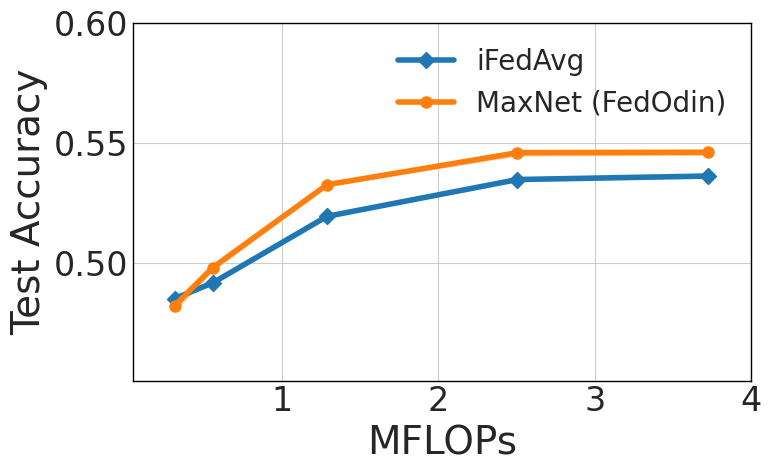

In [41]:
matplotlib.style.use("seaborn-whitegrid")
markersize_def = 8
ws_runs = [maxnet]
ax_fill_list = [["iFedAvg", 0.3], 
                ["MaxNet (FedOdin)", 0.4]]
markers=['D', 'o']
mode="avg"
fed_pareto, error_fed_pareto = get_pareto_curves_df(fedavg_runs, "Test/{model}/Acc", larger_is_better=True, uptil_round=100, rename=True, axis=0, name="iFedAvg")
print(fed_pareto)
print(error_fed_pareto)
ws_pareto, error_ws_pareto = get_pareto_curves_df(ws_runs,  "Test/{model}/Acc", larger_is_better=True, uptil_round=400, rename=True, mode=mode)
print(ws_pareto.keys())
print(error_ws_pareto)
final_df = pd.concat([fed_pareto, ws_pareto], axis=1).loc[subnet_ordering]
final_error_df = pd.concat([error_fed_pareto, error_ws_pareto], axis=1).loc[subnet_ordering]
#     ax = final_df.plot.line(yerr=final_error_df, marker='o')
print(final_df)


'''final_df['iFedAvg'] *= 100
final_df['MaxNet (FedOdin)'] *= 100
final_error_df['iFedAvg'] *= 100
final_error_df['MaxNet (FedOdin)'] *= 100'''
print(final_df)
ax = None
for i, (col, ax_fill) in enumerate(zip(final_df.columns, ax_fill_list)):
    cur_col = final_df.loc[:, [col]]
    cur_col.dropna(inplace=True)
    ax = cur_col.plot.line(marker='o' if markers is None else markers[i], ax=ax, markersize=markersize_def)
    cur_error_col = final_error_df.loc[:, [col]]
    cur_error_col.dropna(inplace=True)
    ax.fill_between(cur_col.index, cur_col[ax_fill[0]] - cur_error_col[ax_fill[0]], cur_col[ax_fill[0]] + cur_error_col[ax_fill[0]], alpha=ax_fill[1])

#ax = final_df.plot.line(marker='o')
#     print(final_df.index)
#     print(final_df["SuperFed"] - final_error_df["SuperFed"])
#ax.fill_between(final_df.index, final_df["iFedAvg"] - final_error_df["iFedAvg"], final_df["iFedAvg"] + final_error_df["iFedAvg"], alpha=0.3)
#ax.fill_between(final_df.index, final_df["SuperFed"] - final_error_df["SuperFed"], final_df["SuperFed"] + final_error_df["SuperFed"], alpha=0.4)
for spine in ax.spines.values():
        spine.set_edgecolor('black')
plt.xlabel("MFLOPs")
plt.xlim(0.05,4) # have uniform x-axis accross all plots
plt.ylim(0.451,0.60) # have uniform y-axis accross all plots
plt.ylabel("Test Accuracy")
plt.tight_layout()
plt.legend(loc=1, ncol=1, prop={'size':20})
plt.savefig("shakespeare.pdf")

In [42]:
print(ws_pareto, "\n", error_ws_pareto)

       MaxNet (FedOdin)
1.290          0.532617
3.722          0.546125
0.316          0.482193
0.560          0.498109
2.506          0.545947 
        MaxNet (FedOdin)
1.290          0.000564
3.722          0.001285
0.316          0.002749
0.560          0.001569
2.506          0.001463


In [43]:
print(fed_pareto, "\n", error_fed_pareto)

0.316    0.485163
0.560    0.491712
1.290    0.519444
2.506    0.534783
3.722    0.536239
Name: iFedAvg, dtype: float64 
 0.316    0.001147
0.560    0.000204
1.290    0.000311
2.506    0.000940
3.722    0.000997
Name: iFedAvg, dtype: float64
